### Import necessary libraries and modules

In [4]:
import pandas as pd
import os
%load_ext zipline
from zipline.api import symbol, order,record, order_target,order_target_percent,get_open_orders
from zipline.utils.calendar_utils import get_calendar
from zipline import run_algorithm
import matplotlib.pyplot as plt
import numpy as np
from zipline.data import bundles
%matplotlib inline
import matplotlib.pyplot as plt
import quantstats as qs
from pyfolio.utils import extract_rets_pos_txn_from_zipline

The zipline extension is already loaded. To reload it, use:
  %reload_ext zipline


In [2]:
def ema(day,price_hist):
    mulitplier = 2/(day+1)
    ema_list = []
    ema_prev = price_hist[0]
    ema_list.append(ema_prev)
    
    for price in price_hist[1:]:
        ema = (price - ema_prev) * mulitplier + ema_prev
        ema_list.append(ema)
        ema_prev =ema
    
    return ema_list

### 1 Apply stop loss manually with MACD indicator

In [5]:
%%capture
calendar = get_calendar('XNYS')
capital_base = 10000

def initialize(context):
    context.i = 0
    context.assets = [symbol("AAPL"), symbol("XOM"), symbol("LLY"),symbol("JPM"),symbol("PEP")]

def handle_data(context, data):
    context.i += 1
    if context.i < 100: return
    for asset in context.assets:

        stop_loss_triggered = False
        price_hist = data.history(asset,'price', bar_count=26, frequency='1d')
        long_term_mavg = data.history(asset, 'close', bar_count=100, frequency='1d').mean()
        trend_up = price_hist[-1] > long_term_mavg
        
        ema_26 = ema(26,price_hist)
        ema_12 = ema(12,price_hist)
        MACD = [ema_12[j]-ema_26[j] for j in range(len(price_hist))]
        signal = ema(9,MACD)
        
        cash = context.portfolio.cash
        price = data.current(asset, "price") # current price of the stock
        volume = data.current(asset, "volume") # current volume of the stock
        
        if asset not in get_open_orders(asset) and data.can_trade(asset):
            if context.portfolio.positions[asset].amount > 0:     # check the assest has long positions
                    cost_basis = context.portfolio.positions[asset].cost_basis
                    stop_loss_price = cost_basis * 0.95  # 5% stop loss

                    if price < stop_loss_price and data.can_trade(asset):
                        order_target(asset, 0)
                        record(stop_loss_triggered=True)

            elif MACD[-1]>signal[-1] and MACD[-2] < signal[-2] and MACD[-1] > 0 and trend_up:    # Bullish crossover
                    order_target_percent(asset,0.3)

            elif MACD[-1]<signal[-1] and MACD[-2] > signal[-2] and MACD[-1] < 0:    # Bearish crossover
                order_target(asset,0) # sell all shares

        record( closing_price = data.current(asset, "close"),
                MACD = MACD[-1],
                signal =signal[-1],
                long_term_mavg=long_term_mavg,
                )

start_date = pd.to_datetime('2018-01-02 00:00:00.0000',format='%Y-%m-%d %H:%M:%S.%f')
end_date = pd.to_datetime('2021-01-01 00:00:00.0000',format='%Y-%m-%d %H:%M:%S.%f')

result = run_algorithm(
    start = start_date,
    end = end_date,
    initialize=initialize,
    handle_data = handle_data,
    trading_calendar=calendar,
    bundle='snp5',
    capital_base=capital_base,
    data_frequency='daily'
)

## Use Benchmark 'SPY' to Compare Manual Stop Loss

Extract a return series with time index from 'SPY' to make it compatible to use in `quantstats` library.

In [6]:
spy_df = pd.read_csv("custom_data/daily/spy.csv")
spy_df.Date = pd.to_datetime(spy_df.Date)
spy_df.set_index('Date',inplace=True)
spy_return_series = spy_df['Adj Close'].pct_change()
spy_return_series = spy_return_series['2018-01-02':'2021-01-01']

Convert the timezone to none to match it with the benchmark 'SPY'.

In [7]:
# spy_return_series.index = spy_return_series.index.tz_localize(None)
# result.index = result.index.tz_localize(None)
result.index = spy_return_series.index

/home/yakub/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/yakub/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/yakub/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axi

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2018-06-04   2018-06-04
End Period                 2020-12-31   2020-12-31
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          43.96%       61.53%
Mean Active Return         0.0%         0.02%
CAGR﹪                     10.25%       13.7%

Sharpe                     0.72         0.84
Prob. Sharpe Ratio         87.1%        90.85%
Smart Sharpe               0.52         0.61
Sortino                    0.98         1.2
Smart Sortino              0.72         0.88
Sortino/√2                 0.7          0.85
Smart Sortino/√2           0.51         0.62
Omega                      1.2          1.2

Max Drawdown               -33.72%      -30.37%
Longest DD Days            203          178
Volatility (ann.)          23.57%       26.34%
R^2                        0.66         0.66
Calmar               

None

0.020889305379232084





,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-02-07,2020-03-23,2020-07-07,152,-30.372641,-27.088475
2,2020-09-03,2020-10-30,2020-12-07,96,-17.485187,-16.950720
3,2018-10-10,2018-12-18,2019-04-05,178,-9.351380,-8.835985
4,2019-04-09,2019-08-05,2019-09-10,155,-8.590663,-7.419880
5,2020-07-21,2020-07-24,2020-07-30,10,-3.821867,-3.097427


Average Long Exposure = 9518.016177248677
Average Short Exposure = 0.0
Average Net Leverage = 0.8402537940634686
Average Gross Leverage = 0.8402537940634686
Max Leverage = 1.5649340902872264



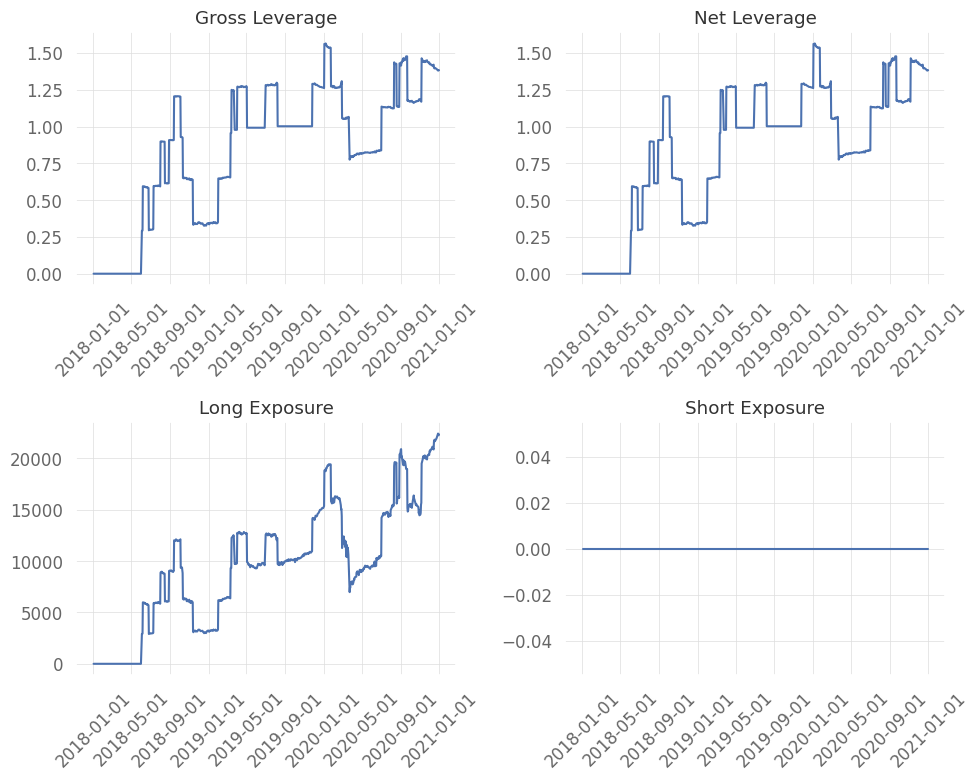

AAPL JPM LLY PEP XOM


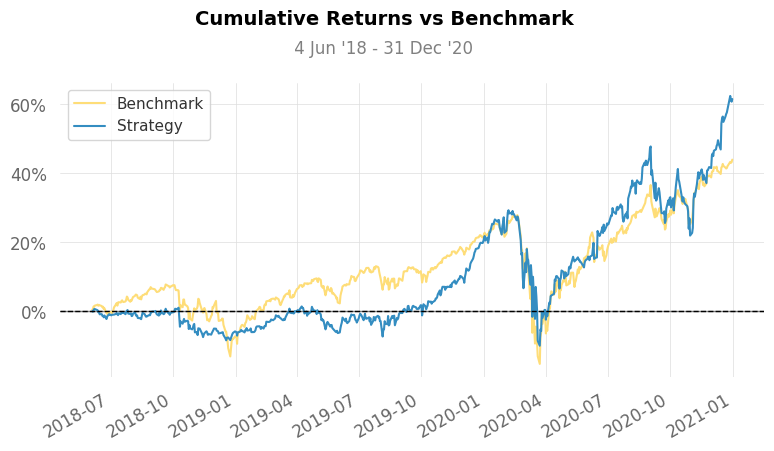

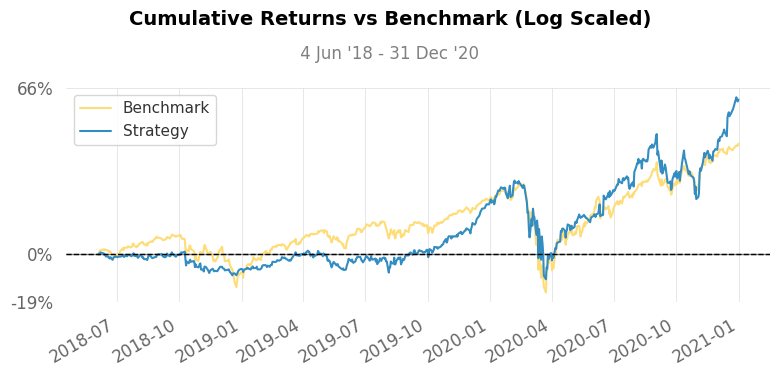

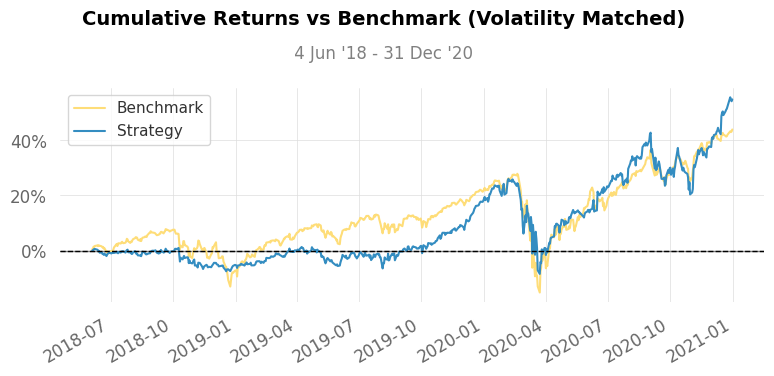

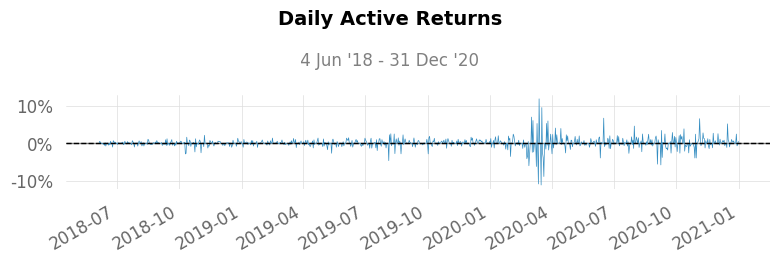

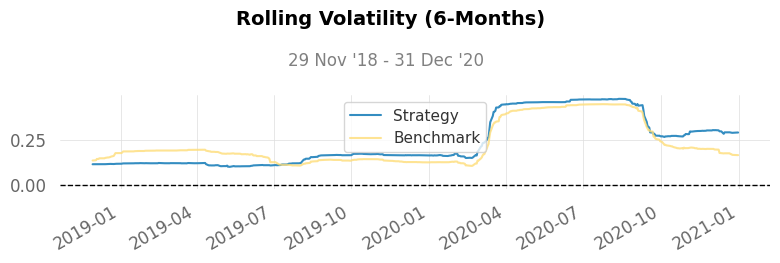

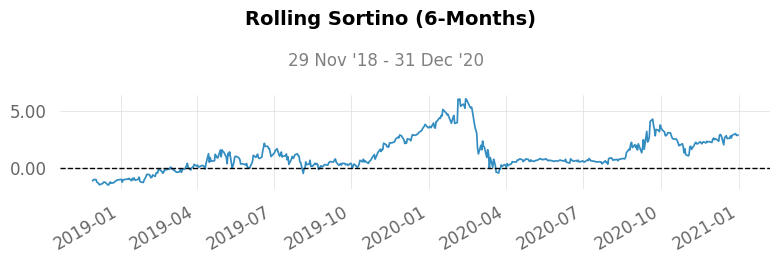

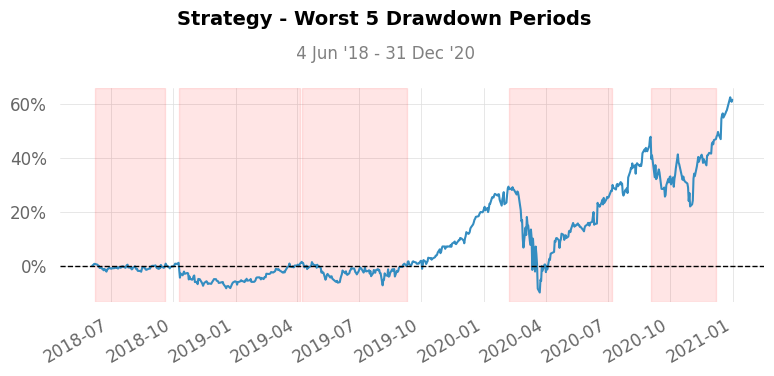

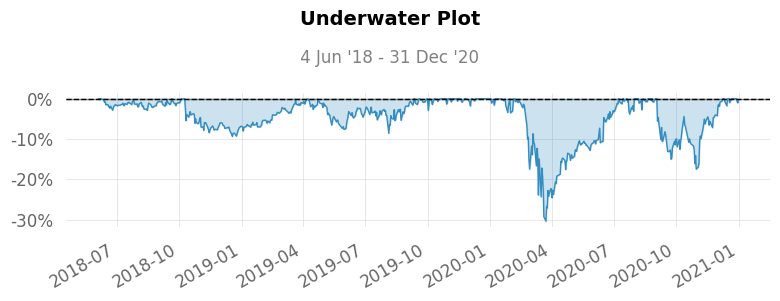

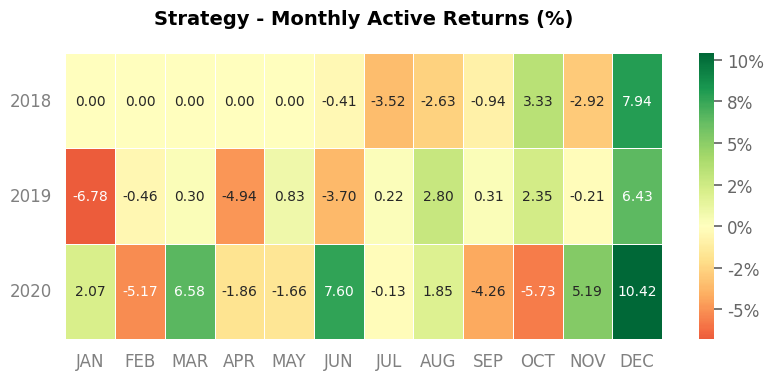

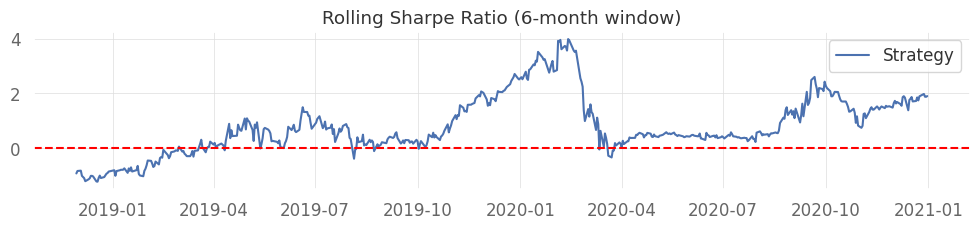

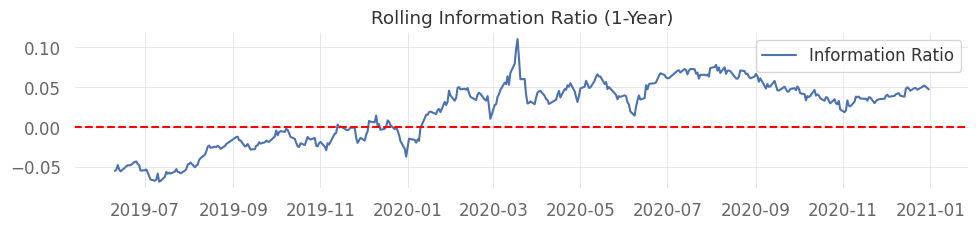

Failed to get ticker '^GSPC' reason: unsupported operand type(s) for -: 'datetime.datetime' and 'str'


[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['^GSPC']: No timezone found, symbol may be delisted


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

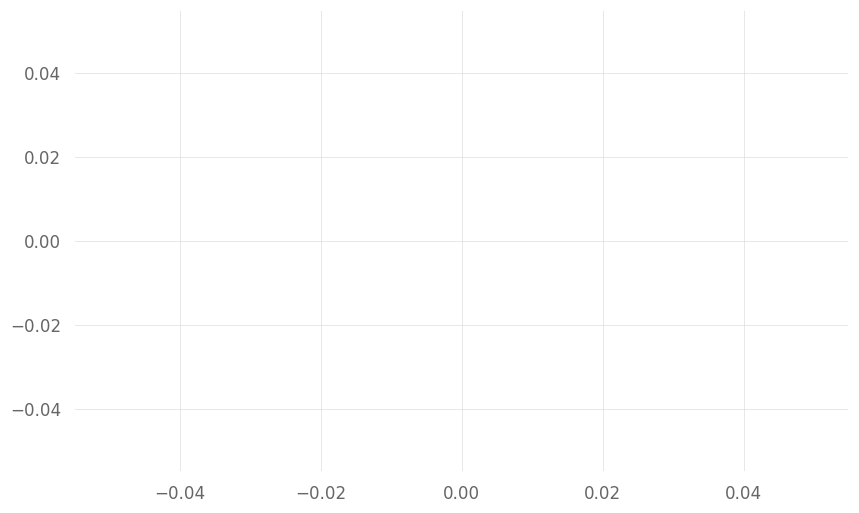

In [8]:
qs.reports.full(result.returns,benchmark=spy_return_series, match_dates = True, df=result)

# 2 

/home/yakub/anaconda3/envs/ml/lib/python3.10/site-packages/quantstats/utils.py:269: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  .pct_change()


/home/yakub/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/yakub/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/yakub/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axi

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2018-06-04   2018-06-04
End Period                 2020-12-31   2020-12-31
Risk-Free Rate             0.0%         0.0%
Time in Market             32.0%        84.0%

Cumulative Return          41.98%       55.45%
Mean Active Return         0.0%         0.03%
CAGR﹪                     9.84%        12.54%

Sharpe                     0.76         0.74
Prob. Sharpe Ratio         94.35%       88.15%
Smart Sharpe               0.54         0.53
Sortino                    1.75         1.07
Smart Sortino              1.26         0.77
Sortino/√2                 1.24         0.76
Smart Sortino/√2           0.89         0.55
Omega                      1.19         1.19

Max Drawdown               -18.95%      -34.23%
Longest DD Days            254          241
Volatility (ann.)          20.49%       28.65%
R^2                        0.0          0.0
Calmar              

None

0.004070406878926806





,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-02-07,2020-03-23,2020-07-30,174,-34.225012,-30.819023
2,2020-09-03,2020-10-30,2020-12-07,96,-17.946054,-17.164311
3,2018-06-08,2019-08-05,2019-12-11,552,-17.114507,-14.739986
4,2020-01-31,2020-01-31,2020-02-04,5,-4.056918,-3.427034
5,2020-01-21,2020-01-27,2020-01-29,9,-3.956498,-2.017432


Average Long Exposure = 9532.036601851853
Average Short Exposure = 0.0
Average Net Leverage = 0.9243972560111268
Average Gross Leverage = 0.9243972560111268
Max Leverage = 1.8115603573057086



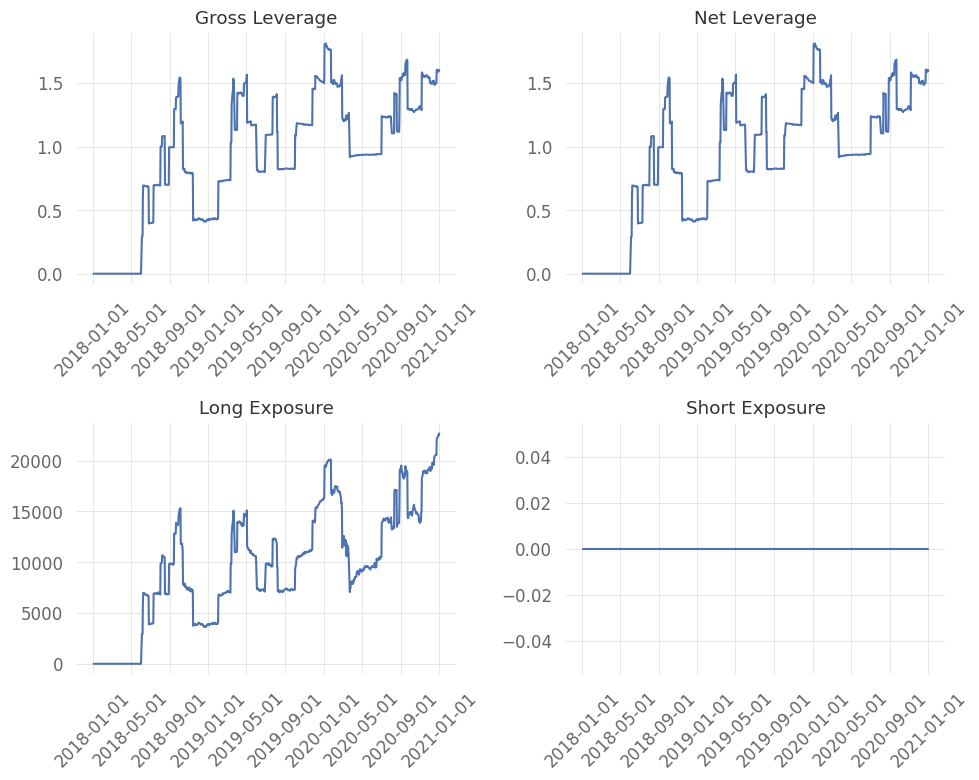

AAPL JPM LLY PEP XOM


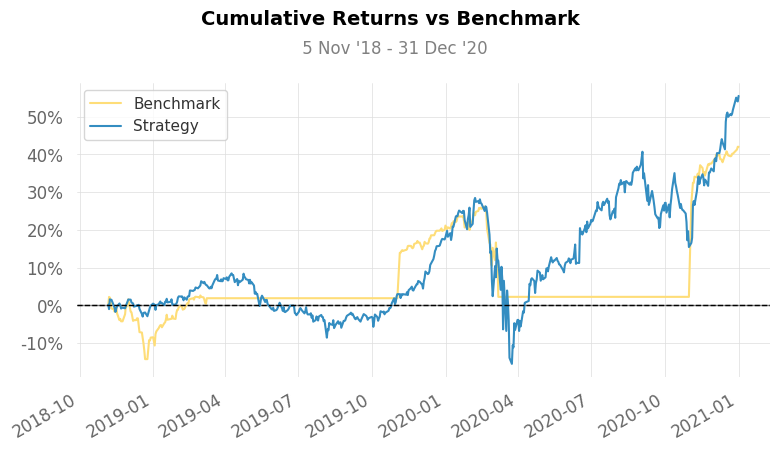

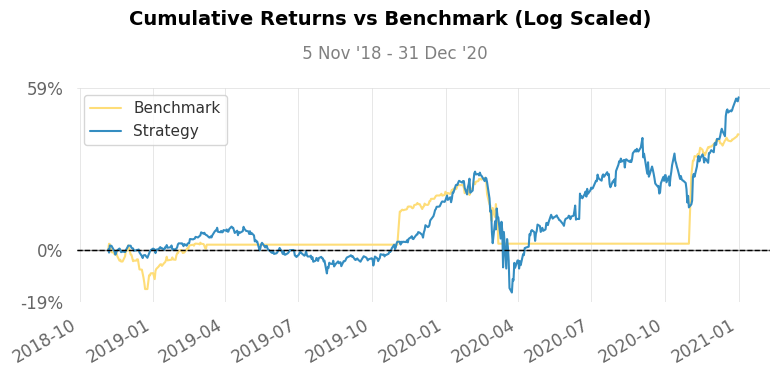

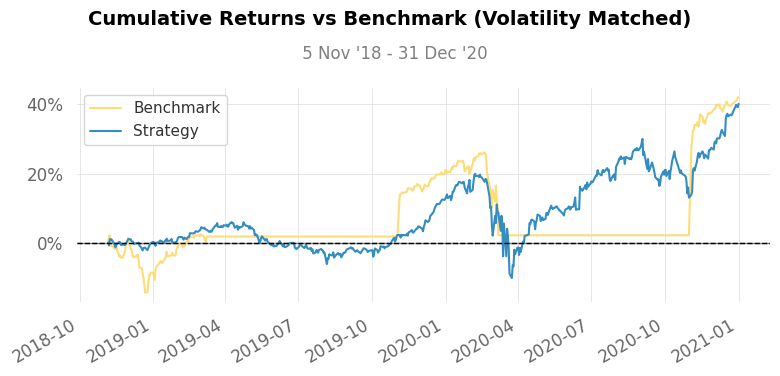

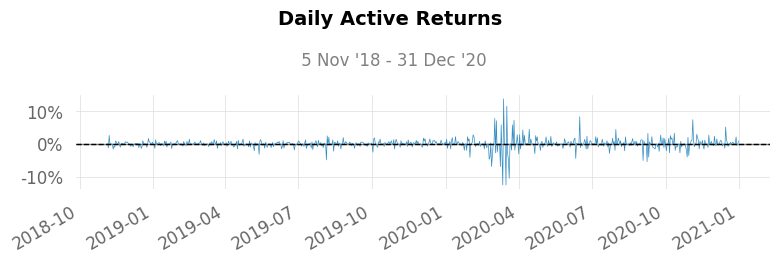

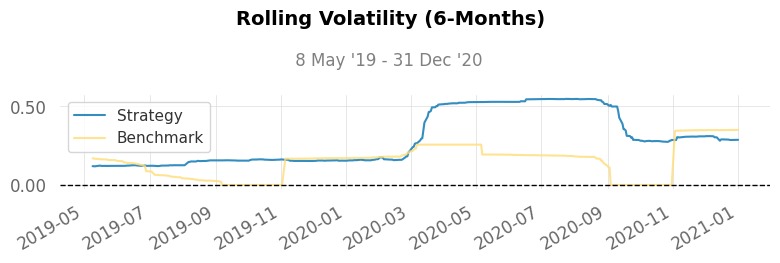

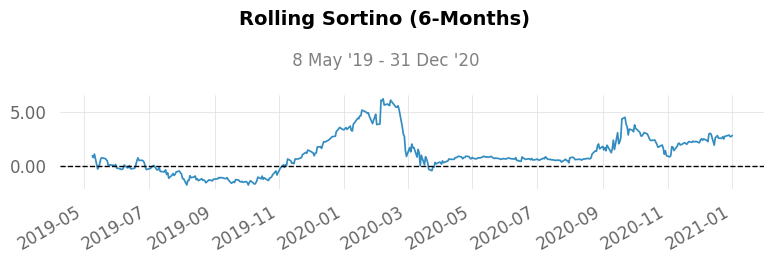

In [52]:
spy_return_series.index = spy_return_series.index.tz_localize(None)
result.index = result.index.tz_localize(None)
qs.reports.full(result.returns,benchmark=spy_return_series, match_dates = True, df=result)

### 2 Apply stop loss with Zipline Built-in Function

In [15]:
%%capture
calendar = get_calendar('XNYS')
capital_base = 10000

def initialize(context):
    context.i = 0
    context.assets = [symbol("AAPL"), symbol("XOM"), symbol("LLY"), symbol("JPM"), symbol("PEP")]

def handle_data(context, data):
    context.i += 1
    if context.i < 100:
        return

    for asset in context.assets:
        stop_loss_triggered = False
        price_hist = data.history(asset,'price', bar_count=26, frequency='1d')
        long_term_mavg = data.history(asset, 'close', bar_count=100, frequency='1d').mean()
        trend_up = price_hist[-1] > long_term_mavg
        
        ema_26 = ema(26,price_hist)
        ema_12 = ema(12,price_hist)
        MACD = [ema_12[j]-ema_26[j] for j in range(len(price_hist))]
        signal = ema(9,MACD)
        
        cash = context.portfolio.cash
        price = data.current(asset, "price") # current price of the stock
        volume = data.current(asset, "volume") # current volume of the stock

        stop_price = price * 0.95  # 5% stop-loss
        limit_price = price * 1.1  # 10% limit price
        
        if asset not in get_open_orders(asset) and data.can_trade(asset):
            if MACD[-1]>signal[-1] and MACD[-2] < signal[-2] and MACD[-1] > 0 and trend_up:    # Bullish crossover
                    order_target_percent(asset,0.3,limit_price=limit_price,stop_price=stop_price)

            elif MACD[-1]<signal[-1] and MACD[-2] > signal[-2] and MACD[-1] < 0:    # Bearish crossover
                order_target(asset,0)

        record( closing_price = data.current(asset, "close"),
                MACD = MACD[-1],
                signal =signal[-1],
                long_term_mavg=long_term_mavg,
                )

start_date = pd.to_datetime('2018-01-02 00:00:00.0000',format='%Y-%m-%d %H:%M:%S.%f')
end_date = pd.to_datetime('2021-01-01 00:00:00.0000',format='%Y-%m-%d %H:%M:%S.%f')

result1 = run_algorithm(
    start = start_date,
    end = end_date,
    initialize=initialize,
    handle_data = handle_data,
    trading_calendar=calendar,
    bundle='snp5',
    capital_base=capital_base,
    data_frequency='daily'
)

## Use Benchmark 'SPY' to Compare Zipline Stop Loss

                    Benchmark    Strategy
------------------  -----------  ----------
Start Period        2018-06-04   2018-06-04
End Period          2020-12-31   2020-12-31
Risk-Free Rate      0.0%         0.0%
Time in Market      100.0%       100.0%

Cumulative Return   43.96%       64.76%
Mean Active Return  0.0%         0.02%
CAGR﹪              10.25%       14.31%

Sharpe              0.72         1.0
Prob. Sharpe Ratio  87.1%        94.13%
Sortino             0.98         1.39
Sortino/√2          0.7          0.98
Omega               1.21         1.21

Max Drawdown        -33.72%      -25.69%
Longest DD Days     203          204

Gain/Pain Ratio     0.16         0.21
Gain/Pain (1M)      0.91         1.14

Payoff Ratio        0.81         0.83
Profit Factor       1.16         1.21
Common Sense Ratio  0.86         1.19
CPC Index           0.54         0.58
Tail Ratio          0.74         0.98
Outlier Win Ratio   5.27         5.2
Outlier Loss Ratio  4.5          4.48

MTD           

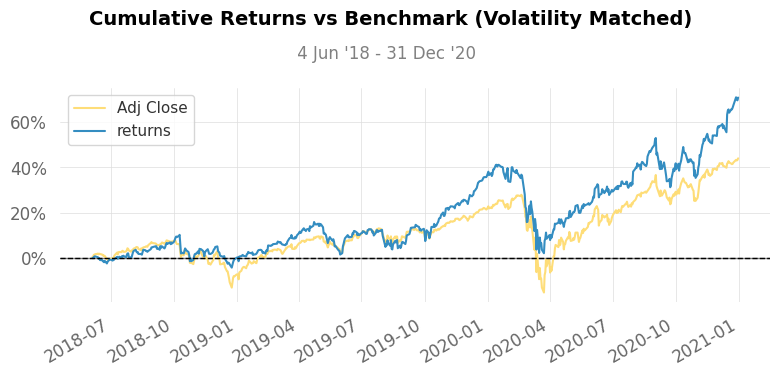

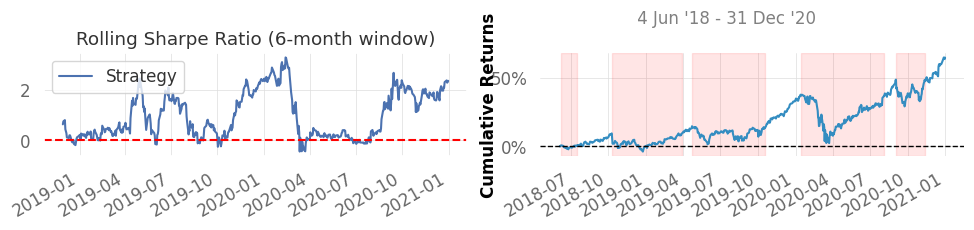

In [16]:
result1.index = spy_return_series.index
qs.reports.basic(result1.returns,benchmark=spy_return_series, match_dates = True, df=result1)